In [6]:
import numpy as np
import pandas as pd
import myvariant
import vcf
from tqdm import tqdm
import Bio
from Bio.Data.IUPACData import protein_letters_3to1
import rhapsody as rd
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, recall_score, precision_score, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier

from utils import parser
from utils import file_info
from validation.cf_matrix import make_confusion_matrix
from validation.f1_distribution import posterior_distribution_f1_score

In [7]:
config = parser.load_config()

In [53]:
features_fname = '/home/pierobartolo/ETH/comp_bio/team02/P2/cache/features_sSNP_train.csv'
features_labels_fname = '/home/pierobartolo/ETH/comp_bio/team02/P2/cache/features_labels_sSNP_train_binary.csv'

In [73]:
X = pd.read_csv(features_fname).drop(columns='ID').to_numpy()
y = pd.read_csv(features_labels_fname).drop(columns='ID').to_numpy().flatten()

In [60]:
#scaler = StandardScaler()
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)
#X = scaler.fit_transform(X)





In [61]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=21, sampling_strategy=0.65)


In [62]:
from sklearn.metrics import balanced_accuracy_score
n_splits = 5
k_fold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=21)

feature_importances = np.zeros(shape=(X.shape[1],))

cm = np.zeros(shape=(2, 2))

val_bmac = []

for train_index, test_index in tqdm(k_fold.split(X, y), total=n_splits):


    X_fit = X[train_index]
    X_val = X[test_index]
    y_fit = y[train_index]
    y_val = y[test_index]

    X_fit, y_fit = rus.fit_resample(X_fit, y_fit)

    label_weights = compute_class_weight('balanced', classes=np.unique(y_fit), y=y_fit) 
    fit_weights = np.asarray([label_weights[j] for j in y_fit])

    model = XGBClassifier(n_jobs=-1, objective='binary:logistic')
    model.fit(X_fit, y_fit, sample_weight=fit_weights)
    
    y_pred = model.predict(X_val)
    y_tr = model.predict(X_fit)

    val_bmac.append(balanced_accuracy_score(y_val, y_pred))

    cm += confusion_matrix(y_val, y_pred)

    feature_importances += (model.feature_importances_ / n_splits)


print(f'Validation scores:\n\t' +
      f'BMAC = {np.mean(val_bmac)} +- {np.std(val_bmac)}.')


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]Validation scores:
	BMAC = 0.7993206124948534 +- 0.01197310083728457.



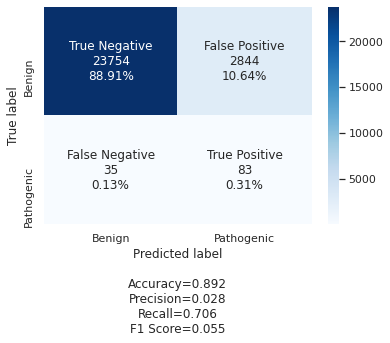

In [64]:
make_confusion_matrix(
    cm / n_splits, 
    group_names=[
        'True Negative',
        'False Positive',
        'False Negative',
        'True Positive'],
    categories=['Benign', 'Pathogenic'], 
    # categories=['Benign', 'Likely Benign', 'Likely Pathogenic', 'Pathogenic'], 
    cmap='Blues')

<AxesSubplot:>

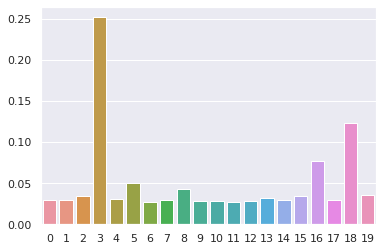

In [65]:
sns.barplot(np.arange(len(feature_importances)), feature_importances)

In [66]:
balanced_accuracy_expected(cm)

0.7989854809535772

<AxesSubplot:ylabel='Density'>

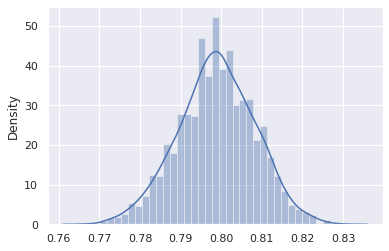

In [69]:
import seaborn as sns, numpy as np
from mclearn.performance import balanced_accuracy_expected,beta_avg_inv_cdf,get_beta_parameters
sns.set_theme();
params = get_beta_parameters(cm)
samples = [beta_avg_inv_cdf(np.random.uniform(0,1), params) for x in range(3000)]
x = pd.Series(x, name="BMAC")
sns.distplot(samples)